In [1]:
%matplotlib notebook
from datetime import datetime, timedelta
import glob
from eigsep_corr import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates

In [14]:
DATA_DIR = "../../data_2024"
files = sorted(glob.glob(f"{DATA_DIR}/2024072*"))  # arrived on the 20th
files = np.array(files)
print(len(files))
hdr = io.read_header(files[0])
print(io.read_header(files[0]).keys())
hdr, data = io.read_file(files[0], header=hdr)
print(data.keys())
print(data['0'].shape)

1155
dict_keys(['dtype', 'infochan', 'nchan', 'acc_bins', 'fpg_file', 'fpg_version', 'sample_rate', 'gain', 'corr_acc_len', 'corr_scalar', 'pol01_delay', 'pam_atten', 'fft_shift', 'pairs', 'acc_cnt', 'sync_time', 'pol23_delay', 'pol45_delay', 'header_size', 'data_start', 'filename', 'filesize', 'nspec', 'freqs', 'dfreq', 'inttime', 'times'])
dict_keys(['0', '1', '2', '3', '4', '5', '02', '04', '24', '13', '15', '35'])
(60, 2, 1024, 1)


[  15  361  426  438  443  444  445  446  447  448  449  461  477  485
  489  612  881  925 1023 1117]


<IPython.core.display.Javascript object>


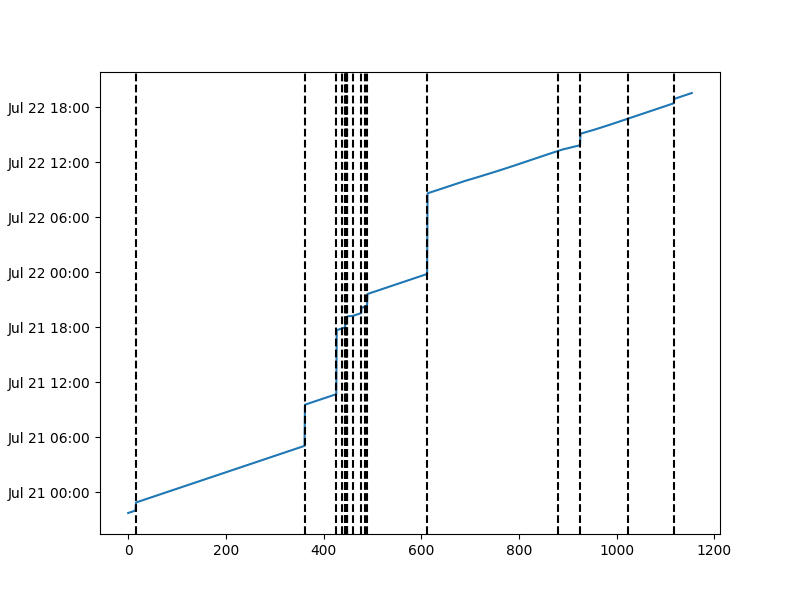

In [15]:
def fname2ts(f):
    t = f[-len("20231014_202203.eig"):-4]
    y = t[:4]
    mo = t[4:6]
    d = t[6:8]
    h = t[9:11]
    mi = t[11:13]
    s = t[13:15]
    dt = datetime.fromisoformat(f"{y}-{mo}-{d} {h}:{mi}:{s}")
    # add one hour to convert from pacific time to local time
    dt = dt + timedelta(hours=1)
    return dt

ftime = np.array([fname2ts(f) for f in files])
timestamps = [ft.timestamp() for ft in ftime]
ix = np.argsort(timestamps)
ftime = ftime[ix]
files = files[ix]

# observing stops when two files are far apart
breaks = np.argwhere(np.diff(timestamps) > np.median(np.diff(timestamps)+1))[:, 0]
print(breaks)

plt.figure(figsize=(8, 6))
plt.plot(ftime)
for b in breaks:
    plt.axvline(b, ls="--", c="k")
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
plt.yticks(rotation=0)
plt.ylabel("Local Time")
plt.show()

In [60]:
observing_windows = {
    "night1": (16, 361),  # sat to sun (all ant on ground)
    "sunday": (361, 426),  # sun morning (all ant on ground)
    "night2": (485, 608),  # sun to mon (box raised)
    "monday_am": (608, 921),  # monday morning/day (rolls + lowering box)
    "monday_pm": (921, 1113),  # raised vivaldi
}

auto = [f"{i}" for i in range(6)]
cross = [f"{i}{i+2}" for i in range(4)] + ["04", "15"]

def load_data(obs_window, pairs=auto+cross):
    mn, mx = observing_windows[obs_window]
    data = {}
    sync_time = None
    acc_cnt = []
    times = []
    for f in files[mn:mx]:
        hdr, dat = io.read_file(f)
        if sync_time is None or hdr["sync_time"] != sync_time:
            print(f, sync_time, hdr["sync_time"])
            sync_time = hdr["sync_time"]
        times.append(hdr["times"])
        acc_cnt.append(hdr["acc_cnt"])
        for k, d in dat.items():
            if k not in pairs:
                continue
            if len(k) == 1:
                d.dtype = io.build_dtype(*hdr["dtype"])
                d = d[..., 0]  # only real part
            else:
                d = d[..., 0] + 1j * d[..., 1]  # complex number
            data[k] = data.get(k, []) + [d]
    for k, v in data.items():
        data[k] = np.concatenate(v, axis=0)
    tmin, tmax = ftime[mn], ftime[mx]
    acc_cnt = np.array(acc_cnt)
    times = np.array(times)
    times = 2 * (times - times[0, 0]) + times[0, 0]  # fixing time calculation bug
    times += 3600  # pacific time to utah time
    return data, hdr, acc_cnt, times, (tmin, tmax)

data, hdr, acc_cnt, times, time_range = load_data("night1", pairs=["0", "1", "2", "3", "02", "13"])
freqs = hdr["freqs"]
print(np.all(np.diff(acc_cnt.ravel()) == 1))  # continuous times

../../data_2024/20240720_215314.eig None 1721537529.7534614
True


In [63]:
times.shape

(345, 60)

In [10]:
hdr

{'dtype': ['int32', '>'],
 'infochan': 2,
 'nchan': 1024,
 'acc_bins': 2,
 'fpg_file': '/usr/local/lib/python3.9/dist-packages/eigsep_corr/data/eigsep_fengine_1g_v2_3_2024-07-08_1858.fpg',
 'fpg_version': [2, 3],
 'sample_rate': 500000000,
 'gain': 4,
 'corr_acc_len': 268435456,
 'corr_scalar': 512,
 'pol01_delay': 0,
 'pam_atten': {0: [8, 8], 1: [8, 8], 2: [4, 4]},
 'fft_shift': 255,
 'pairs': ['0', '1', '2', '3', '4', '5', '02', '04', '24', '13', '15', '35'],
 'acc_cnt': array([20643, 20644, 20645, 20646, 20647, 20648, 20649, 20650, 20651,
        20652, 20653, 20654, 20655, 20656, 20657, 20658, 20659, 20660,
        20661, 20662, 20663, 20664, 20665, 20666, 20667, 20668, 20669,
        20670, 20671, 20672, 20673, 20674, 20675, 20676, 20677, 20678,
        20679, 20680, 20681, 20682, 20683, 20684, 20685, 20686, 20687,
        20688, 20689, 20690, 20691, 20692, 20693, 20694, 20695, 20696,
        20697, 20698, 20699, 20700, 20701, 20702], dtype='>i4'),
 'sync_time': 1721537529.7534614

<IPython.core.display.Javascript object>


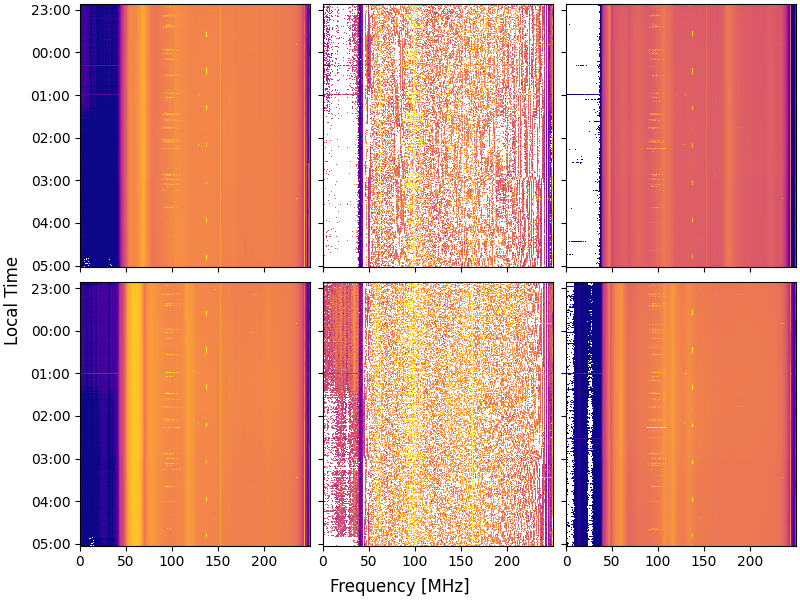

/tmp/ipykernel_30028/1960561752.py:13: RuntimeWarning: invalid value encountered in sqrt
  norm = np.sqrt(data[k[0]]**2 + data[k[1]]**2)[:, 0]
/tmp/ipykernel_30028/1960561752.py:14: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)


In [69]:
def plot_waterfall(data, times, freqs, title=None):
    fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=3, sharex=True, sharey=True, constrained_layout=True)
    auto_ln = colors.LogNorm(vmin=1e2, vmax=1e7)
    cross_ln = colors.LogNorm(vmin=1e-4, vmax=1e0)
    tmin = datetime.fromtimestamp(times[0, 0])
    tmax = datetime.fromtimestamp(times[-1, -1])
    extent = [freqs.min()/1e6, freqs.max()/1e6, tmax, tmin]
    kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
    for i, k in enumerate(["02", "13"]):
        for j in range(2):
            d = np.abs(data[k[j]][:, 0])
            axs[i, 2*j].imshow(d, norm=auto_ln, **kwargs)
        norm = np.sqrt(data[k[0]]**2 + data[k[1]]**2)[:, 0]
        axs[i, 1].imshow(np.abs(data[k][:, 0])/norm, norm=cross_ln, **kwargs)
    axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.supxlabel("Frequency [MHz]")
    fig.supylabel("Local Time")
    if title:
        plt.suptitle(title)
    plt.show()
    
plot_waterfall(data, times, freqs)